In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 30
gamma      = 0.5
n_class = 5
model_use = "pst"

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/PST900_RGBT_Dataset/")
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.9309287071228027


In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, root, phase, n_class=n_class, flip_rate=0.):
        data_dir = os.path.join(root, phase)
        self.img_list = os.listdir(os.path.join(data_dir, 'rgb'))
        self.rgb_dir = os.path.join(data_dir, 'rgb')
        self.label_dir = os.path.join(data_dir, 'labels')
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        idx = idx % len(self.img_list)
        print(idx)
        img = cv2.imread(os.path.join(self.rgb_dir, self.img_list[idx]),cv2.IMREAD_UNCHANGED)
        label = cv2.imread(os.path.join(self.label_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (640, 480), interpolation=cv2.INTER_CUBIC)
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [8]:
# initial dataloader for trainning and validation
train_data = product_dataset(data_dir, phase = 'train')
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [9]:
len(dataiter)

288

## Train

In [10]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_batch{}_epoch{}_RMSprop_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [11]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [12]:
train()

epoch1, iter0, loss: 0.7013148069381714
epoch1, iter10, loss: 0.6796413064002991
epoch1, iter20, loss: 0.6696547269821167
epoch1, iter30, loss: 0.6757975816726685
epoch1, iter40, loss: 0.6654824614524841
Finish epoch 0, time elapsed 90.41652822494507
epoch0, pix_acc: 0.9462980030201099, meanIoU: 0.1234982656713979, IoUs: [1.18341552e-03 2.72087992e-01 9.22818792e-05 2.20629373e-01], recall: [2.82131791e-03 7.87312315e-01 9.26873865e-05 7.61507033e-01], precision: [0.00203431 0.29367388 0.02065728 0.23700599], fscore: [2.36403342e-03 4.27781716e-01 1.84546728e-04 3.61501006e-01]
epoch2, iter0, loss: 0.6540061831474304
epoch2, iter10, loss: 0.6585420966148376
epoch2, iter20, loss: 0.6573308706283569
epoch2, iter30, loss: 0.645121693611145
epoch2, iter40, loss: 0.6451524496078491
Finish epoch 1, time elapsed 90.13233637809753
epoch1, pix_acc: 0.9756839328342015, meanIoU: 0.17047303723314575, IoUs: [0.00209621 0.44115658 0.00158207 0.23705728], recall: [0.00256897 0.83365856 0.00162203 0.2

epoch16, iter20, loss: 0.46231186389923096
epoch16, iter30, loss: 0.43809619545936584
epoch16, iter40, loss: 0.4586484432220459
Finish epoch 15, time elapsed 89.6690981388092
epoch15, pix_acc: 0.9889505456995082, meanIoU: 0.4666332562035627, IoUs: [0.35014811 0.68812506 0.23695165 0.5913082 ], recall: [0.41711241 0.79184109 0.26259179 0.62400187], precision: [0.68563638 0.84009288 0.70817616 0.91860587], fscore: [0.51868104 0.81525365 0.38312193 0.74317244]
epoch17, iter0, loss: 0.4483274519443512
epoch17, iter10, loss: 0.45211416482925415
epoch17, iter20, loss: 0.4175863564014435
epoch17, iter30, loss: 0.4256959557533264
epoch17, iter40, loss: 0.4486194849014282
Finish epoch 16, time elapsed 89.611891746521
epoch16, pix_acc: 0.9878518450701679, meanIoU: 0.44528327909661086, IoUs: [0.28272258 0.65560653 0.23689269 0.60591132], recall: [0.38937497 0.80924498 0.2549493  0.66140361], precision: [0.50791903 0.77544303 0.76983945 0.87837152], fscore: [0.4408164  0.7919835  0.38304485 0.7546

epoch31, iter30, loss: 0.22789233922958374
epoch31, iter40, loss: 0.2327141910791397
Finish epoch 30, time elapsed 89.83454847335815
epoch30, pix_acc: 0.9913774504484955, meanIoU: 0.6044798445520488, IoUs: [0.48914638 0.77878875 0.49992007 0.65006419], recall: [0.66781671 0.8192162  0.65872926 0.70409703], precision: [0.64642873 0.94040973 0.67465211 0.89441372], fscore: [0.65694868 0.87563939 0.66659561 0.78792594]
epoch32, iter0, loss: 0.23061373829841614
epoch32, iter10, loss: 0.23443256318569183
epoch32, iter20, loss: 0.23338474333286285
epoch32, iter30, loss: 0.24169524013996124
epoch32, iter40, loss: 0.21221764385700226
Finish epoch 31, time elapsed 89.9212007522583
epoch31, pix_acc: 0.9912773188838252, meanIoU: 0.6098738262902846, IoUs: [0.53668065 0.77354394 0.49777073 0.63149998], recall: [0.67798917 0.80983555 0.60724141 0.6668232 ], precision: [0.72027652 0.94523964 0.73412519 0.92260844], fscore: [0.6984934  0.87231438 0.66468215 0.77413422]
epoch33, iter0, loss: 0.21841432

epoch46, iter30, loss: 0.15771643817424774
epoch46, iter40, loss: 0.14551806449890137
Finish epoch 45, time elapsed 89.81908845901489
epoch45, pix_acc: 0.9920860573097513, meanIoU: 0.6442204885446747, IoUs: [0.57346224 0.79927671 0.54996437 0.65417863], recall: [0.77390157 0.83942611 0.64062994 0.72127307], precision: [0.68887604 0.94353768 0.79533234 0.8755057 ], fscore: [0.7289177  0.88844223 0.70964776 0.79094073]
epoch47, iter0, loss: 0.15631617605686188
epoch47, iter10, loss: 0.1477302461862564
epoch47, iter20, loss: 0.14696411788463593
epoch47, iter30, loss: 0.1538488268852234
epoch47, iter40, loss: 0.15297642350196838
Finish epoch 46, time elapsed 89.88284015655518
epoch46, pix_acc: 0.9918443580910012, meanIoU: 0.6385851719789385, IoUs: [0.55713893 0.7934379  0.56330939 0.64045447], recall: [0.77940355 0.82611059 0.66010271 0.68495489], precision: [0.66144038 0.9525203  0.79345707 0.90790149], fscore: [0.71559309 0.88482339 0.72066271 0.78082566]
epoch48, iter0, loss: 0.14226670

epoch61, iter30, loss: 0.08593495190143585
epoch61, iter40, loss: 0.08933112770318985
Finish epoch 60, time elapsed 89.59232783317566
epoch60, pix_acc: 0.9917545233832465, meanIoU: 0.6411566178905844, IoUs: [0.59867888 0.78425531 0.53609898 0.6455933 ], recall: [0.70899057 0.81599525 0.61353573 0.67860706], precision: [0.793721   0.95274605 0.80943461 0.92992463], fscore: [0.74896702 0.87908418 0.69800057 0.78463287]
epoch62, iter0, loss: 0.09045087546110153
epoch62, iter10, loss: 0.09617775678634644
epoch62, iter20, loss: 0.09070899337530136
epoch62, iter30, loss: 0.08701875060796738
epoch62, iter40, loss: 0.09038746356964111
Finish epoch 61, time elapsed 89.39583086967468
epoch61, pix_acc: 0.9915647153501159, meanIoU: 0.6363441711884424, IoUs: [0.59466702 0.78082371 0.54899968 0.62088628], recall: [0.7399051  0.81423629 0.62580417 0.64523621], precision: [0.75182957 0.95006993 0.81729346 0.94270177], fscore: [0.74581968 0.8769242  0.70884415 0.76610714]
epoch63, iter0, loss: 0.087313

epoch76, iter30, loss: 0.06282801926136017
epoch76, iter40, loss: 0.06381473690271378
Finish epoch 75, time elapsed 89.63883876800537
epoch75, pix_acc: 0.9916634114583334, meanIoU: 0.6431138561519726, IoUs: [0.60840986 0.76313821 0.53825961 0.66264774], recall: [0.72981951 0.79108563 0.58916316 0.72959614], precision: [0.78528252 0.95575525 0.86168502 0.87836711], fscore: [0.75653585 0.86565897 0.69982935 0.79709938]
epoch77, iter0, loss: 0.06754253059625626
epoch77, iter10, loss: 0.0665661096572876
epoch77, iter20, loss: 0.06568700075149536
epoch77, iter30, loss: 0.06628640741109848
epoch77, iter40, loss: 0.06320279836654663
Finish epoch 76, time elapsed 89.34985852241516
epoch76, pix_acc: 0.9916767713758681, meanIoU: 0.6427430472288661, IoUs: [0.60052189 0.77230469 0.5415464  0.65659922], recall: [0.72734569 0.79931063 0.61495132 0.70236298], precision: [0.77497983 0.95808596 0.8193908  0.90972454], fscore: [0.75040759 0.87152586 0.70260149 0.79270738]
epoch78, iter0, loss: 0.0602954

epoch91, iter20, loss: 0.04562199488282204
epoch91, iter30, loss: 0.05028966814279556
epoch91, iter40, loss: 0.05010487139225006
Finish epoch 90, time elapsed 89.8532485961914
epoch90, pix_acc: 0.9917518898292824, meanIoU: 0.6440266478045977, IoUs: [0.61886373 0.78486042 0.54225279 0.63012966], recall: [0.71202701 0.81733458 0.59164465 0.66914014], precision: [0.82547516 0.95181645 0.86658521 0.91531528], fscore: [0.76456557 0.8794642  0.70319573 0.77310373]
epoch92, iter0, loss: 0.04978897422552109
epoch92, iter10, loss: 0.04900030419230461
epoch92, iter20, loss: 0.04976646602153778
epoch92, iter30, loss: 0.04785099998116493
epoch92, iter40, loss: 0.047394681721925735
Finish epoch 91, time elapsed 93.04073810577393
epoch91, pix_acc: 0.9919234777379918, meanIoU: 0.6479036588464578, IoUs: [0.6123803  0.78717061 0.54192131 0.65014242], recall: [0.72698992 0.81855257 0.59737442 0.69941565], precision: [0.79526829 0.95355791 0.85375634 0.9022343 ], fscore: [0.75959785 0.88091266 0.70291694

## Prediction Result

In [347]:
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)
dataiter = iter(val_loader)

In [415]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(model_name)
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i], cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i], cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)
    x = img[0].astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    y = pred[0].astype(np.uint8)
    l = label[0].numpy().astype(np.uint8)
    print(img.shape)
    #y = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB)
    plt.imsave("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/l_6.jpg", l, cmap='nipy_spectral',vmin = 0, vmax = n_class - 1)
    plt.imsave("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/a_6.jpg", y, cmap='nipy_spectral',vmin = 0, vmax = n_class - 1)
    cv2.imwrite("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/img_6.jpg", x)
    plt.show()


131
(1, 480, 640, 3)


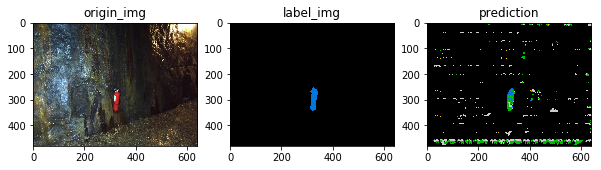

In [482]:
prediction("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/FCNs_batch12_epoch96_RMSprop_lr0.0001.pkl")